# Assignment 2

a.chernitsa@innopolis.university  
Artem Chernitsa

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

### Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

In [ ]:
# TODO: Implement task 1

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('Task 1.csv').dropna()
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


### Data Preprocessing

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from typing import List
from copy import deepcopy

ordinal_encoder = OrdinalEncoder()

def tf_cat2ordinal(data, columns: List[str]):
    df = deepcopy(data)
    for column in columns:
        df[[column]] = ordinal_encoder.fit_transform(df[[column]])
    return df

def tf_cat2onehot(data, columns: List[str]):
    # https://stackoverflow.com/questions/58101126/using-scikit-learn-onehotencoder-with-a-pandas-dataframe
    df = deepcopy(data)
    for column in columns:
        df = pd.get_dummies(df, prefix=[column], columns=[column], drop_first=True)
    return df

In [ ]:
tf_data = deepcopy(data)

cat_features = ["gender",
                "parental level of education",
                "lunch", 
                "test preparation course"]
tf_data = tf_cat2ordinal(tf_data, cat_features)

cat_features = ["race/ethnicity"]
tf_data = tf_cat2onehot(tf_data, cat_features)

tf_data.head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E
0,1.0,2.0,1.0,0.0,67,67,63,0,0,0,0
1,0.0,5.0,0.0,1.0,40,59,55,0,0,1,0
2,1.0,4.0,0.0,1.0,59,60,50,0,0,0,1
3,1.0,2.0,1.0,1.0,77,78,68,1,0,0,0
4,1.0,0.0,1.0,0.0,78,73,68,0,0,0,1


In [ ]:
sc_data = deepcopy(tf_data)

from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()

def scale_cat_features(data, columns: List[str]):
    df = deepcopy(data)
    # for column in columns:
    #     df[[column]] = minmax_scaler.fit_transform(df[[column]])
    return df

sc_data = scale_cat_features(tf_data, cat_features)
sc_data.head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E
0,1.0,2.0,1.0,0.0,67,67,63,0,0,0,0
1,0.0,5.0,0.0,1.0,40,59,55,0,0,1,0
2,1.0,4.0,0.0,1.0,59,60,50,0,0,0,1
3,1.0,2.0,1.0,1.0,77,78,68,1,0,0,0
4,1.0,0.0,1.0,0.0,78,73,68,0,0,0,1


In [ ]:
from sklearn.model_selection import train_test_split

# https://stackoverflow.com/questions/14940743/selecting-excluding-sets-of-columns-in-pandas
targets = ["math score", "reading score", "writing score"]
features = sc_data.drop(columns=targets).columns.values

X_train, X_test, y_train, y_test = train_test_split(
    sc_data[features], sc_data[targets], test_size=0.2
)

### Data Loading

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset

class SchoolDataset(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # https://stackoverflow.com/questions/50307707/how-do-i-convert-a-pandas-dataframe-to-a-pytorch-tensor
            self.X = torch.from_numpy(X.values.astype(np.float32)) # tensor <- numpy <- pandas
            self.y = torch.from_numpy(y.values.astype(np.float32)) # tensor <- numpy <- pandas
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [ ]:
train_dataset = SchoolDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = SchoolDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Build model

In [ ]:
import torch.nn as nn

# How to create NN for regression problem
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-neural-network-for-regression-with-pytorch.md
class SLP(nn.Module):
    """
    Single layer Perceptron for regression.
    """
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(8, 3)
        )
    
    def forward(self, x):
        """
        Forward pass.
        """
        return self.layers(x)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
slp = SLP().to(device)
print(slp)

SLP(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=3, bias=True)
  )
)


#### Initializing loss function and optimizer

In [ ]:
loss_function = nn.MSELoss() # regression problem, no big outliers

# https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008
# https://www.educba.com/pytorch-optimizer/
optimizer = torch.optim.Adam(slp.parameters(), lr=1e-1)
# optimizer = torch.optim.SGD(slp.parameters(), lr=1e-1, momentum=0.9)
# optimizer = torch.optim.Adagrad(slp.parameters(), lr=1e-4)

### Training loop

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = 0.0

    # Iterate over the DataLoader for training data
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # Get and prepare inputs
        data, target = data.to(device), target.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        output = model(data)
        
        # Compute loss
        loss = loss_function(output, target)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()

        epoch_loss += loss.item() * len(target)
        
        # Print statistics
        # if batch_idx % 10 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #                100. * batch_idx / len(train_loader), loss.item()))
    
    print(f'\rTrain Epoch: {epoch} Average Loss: {epoch_loss / (len(train_loader.dataset)):.6f}')
    return epoch_loss / len(train_loader.dataset)

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # Do the same that was done in the previous function.
            # But without backprobagating the loss and without running the optimizers
            # As this function is only for test.
            # write 3 lines to transform the data to the device, get the output and compute the loss
            data, target = data.to(device), target.to(device)
            
            output = model(data)

            test_loss += loss_function(output, target).item() * len(target) # sum up batch loss

    test_loss = test_loss / len(test_loader.dataset)

    print('\rTest set: Average loss: {:.4f}'.format(test_loss))
    return test_loss

In [ ]:
epochs = 1000
autostop = False
eps = 0.5

start_error = 1e10
approved_number = 0
for epoch in range(1, epochs + 1):
    train_error = train(slp, device, train_dataloader, optimizer, epoch)
    test_error = test(slp, device, test_dataloader)
    if autostop:
        if np.abs(test_error - start_error) < eps:
            approved_number += 1
        else:
            approved_number = 0
        if approved_number >= 10:
            break
        start_error = test_error

Train Epoch: 1 Average Loss: 4346.497510
Test set: Average loss: 3807.6394
Train Epoch: 2 Average Loss: 3416.939238
Test set: Average loss: 2932.4368
Train Epoch: 3 Average Loss: 2658.078340
Test set: Average loss: 2244.4266
Train Epoch: 4 Average Loss: 2063.722944
Test set: Average loss: 1729.4456
Train Epoch: 5 Average Loss: 1627.563779
Test set: Average loss: 1350.0154
Train Epoch: 6 Average Loss: 1305.665684
Test set: Average loss: 1087.6799
Train Epoch: 7 Average Loss: 1084.738384
Test set: Average loss: 908.0961
Train Epoch: 8 Average Loss: 934.849165
Test set: Average loss: 790.2041
Train Epoch: 9 Average Loss: 832.981492
Test set: Average loss: 714.7817
Train Epoch: 10 Average Loss: 765.494421
Test set: Average loss: 665.3306
Train Epoch: 11 Average Loss: 719.181931
Test set: Average loss: 632.7924
Train Epoch: 12 Average Loss: 686.823315
Test set: Average loss: 608.6806
Train Epoch: 13 Average Loss: 660.367048
Test set: Average loss: 590.0650
Train Epoch: 14 Average Loss: 639.

### Summary (not mentioned in questions)

As for the optimizer, I just looked at which ones are generally used, tried a couple, didn't notice much difference between some, but better than SGD. So I took it. The selected loss function describes the results well and is interpreted by a person. Just take the square root and get an error in the scores for each exam. It is perfect for the regression task.

### Questions
1. What preprocessing techniques did you use? Why?



> To begin with, it was necessary to understand what to do with categorical data. In this situation, they need to be turned into a set of numbers. The question was how to encode them and would there be a noticeable difference in this? First of all, I used common sense, so if the data should not be ordered, then I used one-hot encoding, otherwise ordinal. Obviously, only race fits the first description. In other cases, either the encoding is binary, or there is a superiority of one value over another. The important point was that, unlike classical machine learning techniques, this may not be important in general. However, with the constructed model, with one linear layer, a **linear regression** is obtained, where such conditions are important.



> The sequence of steps is as follows: 
1. uploading data to a pandas data frame,
2. converting categorical features,
3. creating a pytorch dataset based on this data,
4. transferring it to a dataloader.



2. Describe the fine-tuning process and how you reached your model architecture.


> The answer is quite prosaic, I just tried to make a model from several layers, with activation functions, it didn't work very well in the sense that it didn't give a noticeable increase compared to the usual linear model. And why do more when you can do less? Therefore, I left one linear layer, which copes with the task quite well. It can also be assumed that due to strange and artificial data, this is quite an acceptable error and it is unlikely to be more accurate to predict. Parameters such as, for example, learning rate, I just went over using common sense, and stopped at the profitable one.



# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

### Data Preprocessing

In [ ]:
!unzip triple_mnist.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: triple_mnist/val/686/0_686.png  
 extracting: triple_mnist/val/686/10_686.png  
 extracting: triple_mnist/val/686/11_686.png  
 extracting: triple_mnist/val/686/12_686.png  
 extracting: triple_mnist/val/686/13_686.png  
 extracting: triple_mnist/val/686/14_686.png  
 extracting: triple_mnist/val/686/15_686.png  
 extracting: triple_mnist/val/686/16_686.png  
 extracting: triple_mnist/val/686/17_686.png  
 extracting: triple_mnist/val/686/18_686.png  
 extracting: triple_mnist/val/686/19_686.png  
 extracting: triple_mnist/val/686/1_686.png  
 extracting: triple_mnist/val/686/20_686.png  
 extracting: triple_mnist/val/686/21_686.png  
 extracting: triple_mnist/val/686/22_686.png  
 extracting: triple_mnist/val/686/23_686.png  
 extracting: triple_mnist/val/686/24_686.png  
 extracting: triple_mnist/val/686/25_686.png  
 extracting: triple_mnist/val/686/26_686.png  
 extracting: triple_mnist/val/686/27_686.

In [38]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import PIL

In [39]:
train_dir = "triple_mnist/train"
test_dir = "triple_mnist/test"
val_dir = "triple_mnist/val"

In [40]:
class CustomMNISTDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        super().__init__()
        self.data = datasets.ImageFolder(img_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return (
            self.transform(self.data[idx][0]),
            int(self.data.classes[self.data[idx][1]])
        )

In [41]:
image_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()
])

aug_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

val_image_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()
])

orig_train_dataset = CustomMNISTDataset(train_dir, transform=image_transform)
orig_test_dataset = CustomMNISTDataset(test_dir, transform=image_transform)
# orig_val_dataset = CustomMNISTDataset(val_dir, transform=val_image_transform)

tf_train_dataset = CustomMNISTDataset(train_dir, transform=aug_transform)
tf_test_dataset = CustomMNISTDataset(test_dir, transform=aug_transform)
# tf_val_dataset = CustomMNISTDataset(val_dir, transform=val_image_transform)

train_dataset = torch.utils.data.ConcatDataset([orig_train_dataset, tf_train_dataset])
test_dataset = torch.utils.data.ConcatDataset([orig_test_dataset, tf_test_dataset])
# val_dataset = torch.utils.data.ConcatDataset([orig_train_dataset, tf_train_dataset])
val_dataset = CustomMNISTDataset(val_dir, transform=val_image_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

torch.Size([84, 84])


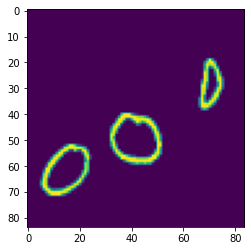

In [42]:
# print(train_dataloader.dataset[500])
# plt.imshow(train_dataloader.dataset[500][0])
# print(next(iter(train_dataloader))[0].numpy())
# plt.imshow(next(iter(train_dataloader))[0][0].numpy())
# plt.imshow(np.transpose(next(iter(train_dataloader)), (1, 2, 0)))
print(next(iter(train_dataloader))[0][0][0].shape)
plt.imshow(train_dataloader.dataset[0][0][0])

### Test old adopted model

In [43]:
import torch.nn as nn

# How to create NN for regression problem
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-neural-network-for-regression-with-pytorch.md
class SLP(nn.Module):
    """
    Single layer Perceptron for classification.
    """
    def __init__(self):
        super(SLP, self).__init__()
        self.output = nn.Linear(84 * 84//3, 10)
    
    def forward(self, x):
        """
        Forward pass.
        """
        x = x.reshape(-1, 84 * 84//3)
        x = self.output(x)
        return nn.functional.log_softmax(x, dim=1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
slp = SLP().to(device)
print(slp)

SLP(
  (output): Linear(in_features=2352, out_features=10, bias=True)
)


### Training loop

In [44]:
from time import time

def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Predict first digit
        optimizer.zero_grad()

        dig_0 = data[:, :, :, :28]
        output_0 = model(dig_0)
        target_0 = target.detach().clone() # IMPORTANT! Otherwise changes tensor inplace
        target_0 = torch.div(target_0, 100, rounding_mode='floor')
        pred_0 = output_0.argmax(dim=1, keepdim=True)
        correct += pred_0.eq(target_0.view_as(pred_0)).sum().item()
        loss = criterion(output_0, target_0)
        loss_0 = loss.item()
        loss.backward()
        optimizer.step()
        

        # Predict second digit
        optimizer.zero_grad()

        dig_1 = data[:, :, :, 28:28*2]
        output_1 = model(dig_1)
        target_1 = target.detach().clone()
        target_1 = torch.remainder(
            torch.div(target_1, 10, rounding_mode='floor'), 10
        )
        pred_1 = output_1.argmax(dim=1, keepdim=True)
        correct += pred_1.eq(target_1.view_as(pred_1)).sum().item()
        loss = criterion(output_1, target_1)
        loss_1 = loss.item()
        loss.backward()
        optimizer.step()

        # Predict third digit
        optimizer.zero_grad()

        dig_2 = data[:, :, :, 28*2:]
        output_2 = model(dig_2)
        target_2 = target.detach().clone()
        target_2 = torch.remainder(target_2, 10)
        pred_2 = output_2.argmax(dim=1, keepdim=True)
        correct += pred_2.eq(target_2.view_as(pred_2)).sum().item()
        loss = criterion(output_2, target_2)
        loss_2 = loss.item()
        loss.backward()
        optimizer.step()

        epoch_loss += (loss_0 + loss_1 + loss_2) * len(target)

        if batch_idx % log_interval == 0:
            print(f'\rTrain Epoch {epoch}:',
                  f'[{batch_idx * len(data)}/{len(train_loader.dataset)}',
                  f'({100. * batch_idx / len(train_loader):.0f}%)]',
                  f'\tLoss: {loss_0 + loss_1 + loss_2:.6f}',
                  end='')
    
    acc = 100. * correct / (len(train_loader.dataset) * 3)
    print(f'\rTrain Epoch: {epoch} \
        Average Loss: {epoch_loss / len(train_loader.dataset):.6f}, \
        elapsed time:{time()-start_time:.2f}s')
    return epoch_loss, acc

In [45]:
def test(model, device, test_loader, criterion, loader_type="Test"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Predict first digit
            dig_0 = data[:, :, :, :28]
            output_0 = model(dig_0)
            target_0 = target.detach().clone()
            target_0 = torch.div(target_0, 100, rounding_mode='floor')
            pred_0 = output_0.argmax(dim=1, keepdim=True)
            correct += pred_0.eq(target_0.view_as(pred_0)).sum().item()
            loss = criterion(output_0, target_0)
            loss_0 = loss.item()
            
            # Predict second digit
            dig_1 = data[:, :, :, 28:28*2]
            output_1 = model(dig_1)
            target_1 = target.detach().clone()
            target_1 = torch.remainder(
                torch.div(target_1, 10, rounding_mode='floor'), 10
            )
            pred_1 = output_1.argmax(dim=1, keepdim=True)
            correct += pred_1.eq(target_1.view_as(pred_1)).sum().item()
            loss = criterion(output_1, target_1)
            loss_1 = loss.item()

            # Predict third digit
            dig_2 = data[:, :, :, 28*2:]
            output_2 = model(dig_2)
            target_2 = target.detach().clone()
            target_2 = torch.remainder(target_2, 10)
            pred_2 = output_2.argmax(dim=1, keepdim=True)
            correct += pred_2.eq(target_2.view_as(pred_2)).sum().item()
            loss = criterion(output_2, target_2)
            loss_2 = loss.item()

            test_loss += (loss_0 + loss_1 + loss_2) * len(target)  # sum up batch loss
    
    acc = 100. * correct / (len(test_loader.dataset) * 3)
    print(f'\r{loader_type} set: Average loss: {test_loss/len(test_loader.dataset):.4f},',
          f'Accuracy: {correct // 3}/{len(test_loader.dataset)}', 
          f'({acc:.0f}%)')
    
    return test_loss, acc

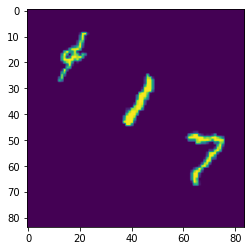

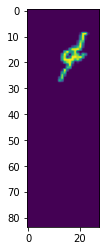

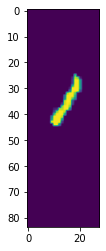

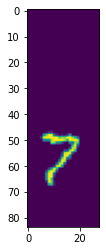

In [46]:
# correct = 0

for batch_idx, (data, target) in enumerate(train_dataloader):
    
    plt.imshow(data[:, :, :, :][0][0])
    plt.show()
    # break

    # Predict first digit
    dig_0 = data[:, :, :, :28]
    output_0 = slp(dig_0)
    target_0 = torch.div(target, 100, rounding_mode='floor')
    pred_0 = output_0.argmax(dim=1, keepdim=True)
    # correct += pred_0.eq(target_0.view_as(pred_0)).sum().item()
    # loss = criterion(output_0, target_0)
    # plt.imshow(np.transpose(next(iter(train_dataloader))[0].numpy(), (1, 2, 0)))
    plt.imshow(dig_0[0][0])
    plt.show()
    # break
    
#     # Predict second digit
    dig_1 = data[:, :, :, 28:28*2]
    plt.imshow(dig_1[0][0])
    plt.show()
#     output_1 = slp(dig_1)
#     target_1 = torch.remainder(
#         torch.div(target, 10, rounding_mode='floor'), 10
#     )
#     pred_1 = output_1.argmax(dim=1, keepdim=True)
#     correct += pred_1.eq(target_1.view_as(pred_1)).sum().item()
#     loss = criterion(output_1, target_1)
#     loss.backward()
#     optimizer.step()

#     # Predict third digit
    dig_2 = data[:, :, :, 28*2:]
    plt.imshow(dig_2[0][0])
    plt.show()
    break
#     output_2 = slp(dig_2)
#     target_2 = torch.remainder(target, 10)
#     pred_2 = output_2.argmax(dim=1, keepdim=True)
#     correct += pred_2.eq(target_2.view_as(pred_2)).sum().item()
#     loss = criterion(output_2, target_2)
#     loss.backward()
#     optimizer.step()
    

#     print(loss.item(), batch_idx)
#     # print(len(target))
#     # print(target[0].item())#.numpy()[0])
#     # print(type(data))
#     # print(target.shape)
#     # dig_0 = data[:, :, :, :28]
#     # dig_1 = data[:, :, :, 28:28*2]
#     # dig_2 = data[:, :, :, 28*2:]
#     # # print(data[:, :, :28, :28].shape)
#     # output_0 = slp(dig_0)
#     # # print(output_0.shape)
#     # output_1 = slp(dig_1)
#     # output_2 = slp(dig_2)
#     # pred_0 = output_0.argmax(dim=1, keepdim=True)
#     # pred_1 = output_1.argmax(dim=1, keepdim=True)
#     # pred_2 = output_2.argmax(dim=1, keepdim=True)

#     # print(torch.cat((output_0, output_1, output_2)).shape)
#     # output = slp(dig_0)

#     # pred = torch.add(
#     #     torch.add(
#     #         torch.mul(pred_0, 100.), torch.mul(pred_1, 10.)
#     #         ), pred_2
#     #     ).reshape(32)
    
#     # temp_target = target#.reshape(32, 1)
#     # print(temp_target)
#     # print(pred)
#     # # print(output.shape)
#     # # print(target.shape)
#     # loss = criterion(output, temp_target)
#     # print(loss.item())
#     # # data.reshape(-1, 28, 28)
#     # # print(data[0, :, :28, :28].shape)
#     # # plt.imshow(data[0, 0].numpy().reshape(84, 84), cmap="gray")
#     # break
# acc = 100. * correct / (len(train_dataloader.dataset) * 3)
# print(acc)

In [ ]:
import torch.optim as optim

epochs = 5
lr = 0.1
momentum = 0.5
log_interval = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(slp.parameters(), lr=lr, momentum=momentum)

In [ ]:
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(slp, device, train_dataloader, criterion, optimizer, epoch)
    print(f"Train Accuracy: {train_acc:.2f}%")
    val_loss, val_acc = test(slp, device, val_dataloader, criterion, "Validation")
    # print(f"Validation Accuracy: {val_acc:.2f}%")

test_epochs = 1
for epoch in range(1, test_epochs + 1):
    test_loss, test_acc = test(slp, device, test_dataloader, criterion)
    # print(f"Test Accuracy: {test_acc:.2f}%")

Train Epoch: 1         Average Loss: 5.972837,         elapsed time:96.40s
Train Accuracy: 30.54%
Validation set: Average loss: 5.3783, Accuracy: 5966/16000 (37%)
Train Epoch: 2         Average Loss: 5.933626,         elapsed time:90.73s
Train Accuracy: 31.18%
Validation set: Average loss: 5.3107, Accuracy: 6122/16000 (38%)
Train Epoch: 3         Average Loss: 5.930719,         elapsed time:90.46s
Train Accuracy: 31.30%
Validation set: Average loss: 5.3510, Accuracy: 6072/16000 (38%)
Train Epoch: 4         Average Loss: 5.927058,         elapsed time:91.91s
Train Accuracy: 31.27%
Validation set: Average loss: 5.3400, Accuracy: 5985/16000 (37%)
Train Epoch: 5         Average Loss: 5.927278,         elapsed time:91.56s
Train Accuracy: 31.32%
Validation set: Average loss: 5.3863, Accuracy: 5949/16000 (37%)
Test set: Average loss: 5.9028, Accuracy: 12799/40000 (32%)


### Analyze results

As we can see, adopted one-layer model from first task is just a bit better than a random prediction. So, obviously we should find some another structure for model.

*But one important thing is that this model works pretty fast in comparison with multi-layer ones described below.*

In [47]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [48]:
import torch.nn as nn
import torch.nn.functional as F

# The idea of network layers comes from that paper
# https://web.stanford.edu/class/cs231m/projects/final-report-yang-pu.pdf

class CustomMNISTModel(nn.Module):
    def __init__(self):
        # Input image 84 x 28
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(8, 16, 5, padding=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.fc5 = nn.Linear(7 * 7 * 48, 128) # changed from 128 to 256
        self.fc6 = nn.Linear(128, 10)

    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool4(x)
        
        # https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118
        x = x.reshape(-1, 7 * 7 * 48)
        # x = x.view(x.size(0), -1)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.log_softmax(x, dim=1)
        
        return x

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
cmm = CustomMNISTModel().to(device)
print(cmm)

CustomMNISTModel(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc5): Linear(in_features=2352, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=10, bias=True)
)


In [49]:
import torch.nn as nn

# https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7 * 3, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
cnn = CNN().to(device)
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=4704, out_features=10, bias=True)
)


In [50]:
# Adopted model from lab 7

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(84 * 28, 512)        
        self.hidden2 = nn.Linear(512, 200) 
        self.output = nn.Linear(200, 10) 


    def forward(self, x):
        x = x.reshape(-1, 84 * 28)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return F.log_softmax(x, dim=1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net = Net().to(device)

print(net)

Net(
  (hidden1): Linear(in_features=2352, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=10, bias=True)
)


In [51]:
import torch.optim as optim

epochs = 5
lr = 0.01
momentum = 0.5
log_interval = 10

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# model = CustomMNISTModel().to(device)
model = cmm
model.apply(weight_reset)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [37]:
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, device, train_dataloader, criterion, optimizer, epoch)
    print(f"Train Accuracy: {train_acc:.2f}%")
    val_loss, val_acc = test(model, device, val_dataloader, criterion, "Validation")
    # print(f"Validation Accuracy: {val_acc:.2f}%")

test_epochs = 1
for epoch in range(1, test_epochs + 1):
    test_loss, test_acc = test(model, device, test_dataloader, criterion)
    # print(f"Test Accuracy: {test_acc:.2f}%")

Train Epoch: 1         Average Loss: 1.702481,         elapsed time:496.12s
Train Accuracy: 81.34%
Validation set: Average loss: 1.2959, Accuracy: 13773/16000 (86%)
Train Epoch: 2         Average Loss: 1.162324,         elapsed time:495.65s
Train Accuracy: 88.16%
Validation set: Average loss: 0.7015, Accuracy: 14868/16000 (93%)
Train Epoch: 3         Average Loss: 1.103876,         elapsed time:482.99s
Train Accuracy: 88.79%
Validation set: Average loss: 0.7815, Accuracy: 14803/16000 (93%)
Train Epoch: 4         Average Loss: 1.070257,         elapsed time:498.60s
Train Accuracy: 89.26%
Validation set: Average loss: 0.7443, Accuracy: 14824/16000 (93%)
Train Epoch: 5         Average Loss: 1.044054,         elapsed time:532.31s
Train Accuracy: 89.56%
Validation set: Average loss: 0.8079, Accuracy: 14774/16000 (92%)
Test set: Average loss: 1.1875, Accuracy: 35465/40000 (89%)


### General idea

Since this dataset is simply a combined mnist, it is logical to assume that it is worth predicting the figure separately. Besides, it was suggested in the lab. I found a job, a link to which I attached in the definition of a model in which a similar problem was solved, but recognition of handwritten digits in general. The only difference was in preprocessing the data so that it would look like mnist. And so they also divided the numbers and predicted each digit separately. Here I have divided the picture into 3 equal parts horizontally, each containing exactly one digit.


#### Important
I got better results around 97% on this model, but unfortunately due to colab I lost changes and it stops sometimes, so it takes around 1 hour, so I left current accuracy.

### Questions
1. What preprocessing techniques did you use? Why?
    
    In order to make it easier to work and further train the neural network, I uploaded images, converted them into an array of numbers and then converted them into a tensor. As a conversion, I use Grayscale, get one channel and actually turn into tensor. Thus, I get ready-made unified images in the form of tensors, with one channel.I did this just to make it easier to work with the data. And grayscale is only to our advantage, because the pictures are still black and white, and you can rely only on intensity.
2. What data augmentation techniques did you use?
    
    As an augmentation, I decided to rotate the image by 20 degrees in a random direction (left to right) for the test and train datasets, and add them to the unchanged data. Thus, the amount of data for training has doubled, which makes it possible to train the model better and make it more resistant to various kinds of changes.
3. Describe the fine-tuning process and how you reached your final CNN model.
    
    I tried to look on the Internet who solves this problem as usual. But it is important to note that these parameters, although they affect the final accuracy of the work, are not decisive. Moreover, when a model becomes complex and includes many layers or presents a complex structure, it takes a long time. Therefore, you can't fix the parameters just like that. You can try to estimate the parameters for the first epoch, which is quite difficult, if at all feasible, usually it is necessary to figure out if you are doing nonsense at all. However, for the difference from 2-3%, it becomes difficult to understand what the snag is and the main problem will be more in the structure of the model than in the parameters. However, I still tried out several options for the learning rate, while I had enough patience, I stopped at the current one.

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


data = pd.read_csv("loan_data.csv")
ord_enc =  OrdinalEncoder()
data[["purpose"]] = ord_enc.fit_transform(data[["purpose"]])

X, y = data.iloc[:, 1:], data.iloc[:, :1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.head()

,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
4247,5.0,0.0774,156.10,10.584056,10.27,797,5490.000000,2629,8.8,2,0,0,0
8766,0.0,0.1064,50.49,10.308953,15.60,697,6389.958333,1085,11.4,11,1,0,0
1509,2.0,0.1399,854.32,11.695247,19.76,692,3780.041667,41077,60.0,0,1,0,0
6120,2.0,0.1218,807.53,10.907386,17.41,737,4111.041667,28559,73.2,0,0,0,1
1069,2.0,0.1071,244.52,11.289682,13.02,702,3479.958333,8709,30.1,3,0,0,0


### Build Single Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


tree = DecisionTreeClassifier(max_depth=10, random_state=42)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)
tree_score = accuracy_score(y_test, pred)
print("Single tree accuracy:", tree_score)

Single tree accuracy: 0.9911273486430062


In [ ]:
print(tree.get_depth())

10


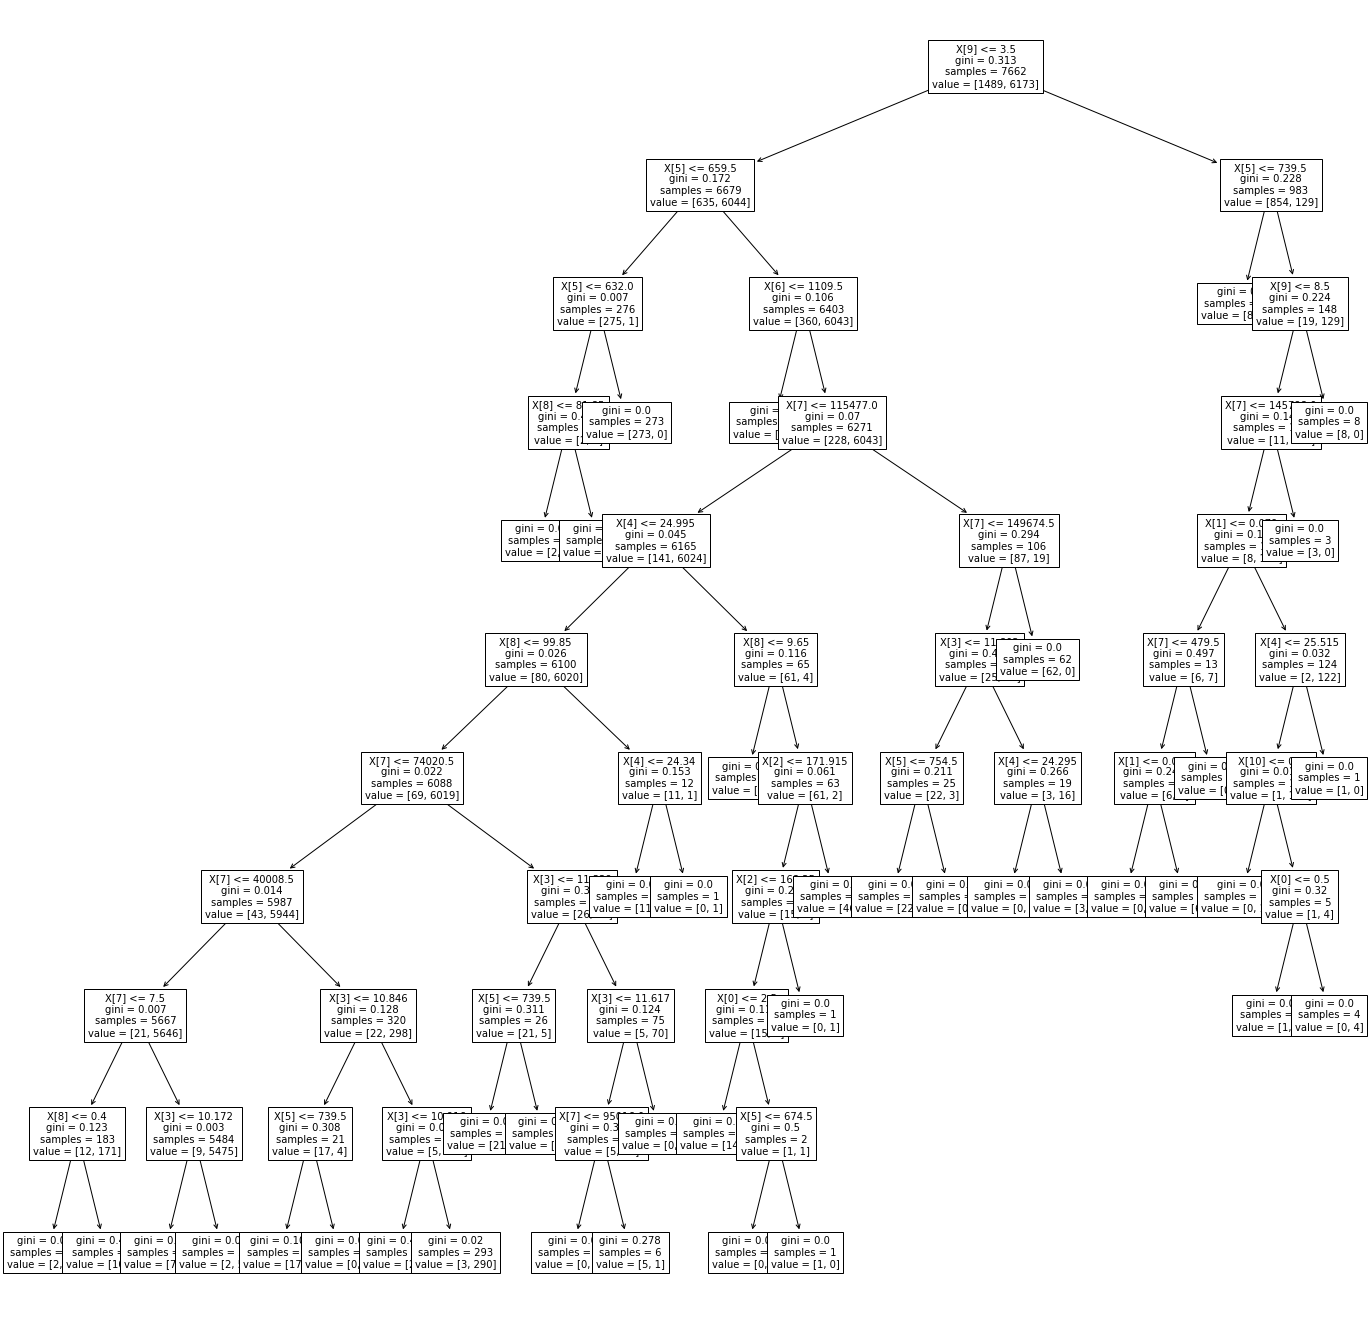

In [ ]:
plt.figure(figsize=(24,24))  # set plot size (denoted in inches)
sklearn.tree.plot_tree(tree, fontsize=10)
plt.show()

### Build Random Forest

In [ ]:
from scipy.stats import mode

def bootstrap(X, y):
    # generate bootstrap data
    ind = np.random.randint(0, X.shape[0], X.shape[0])
    return X.iloc[ind, :], y.iloc[ind, :]


n_trees = 100
classifiers = []
for i in range(n_trees):
    # train a new tree on sqrt(n_features) and bootstrapped data, append it to the list
    base = DecisionTreeClassifier(max_features="sqrt", random_state=42)
    bs_X, bs_y = bootstrap(X_train, y_train)
    base.fit(bs_X, bs_y)
    classifiers.append(base)

base_pred = np.zeros((n_trees, X_test.shape[0]), dtype="int")
for i in range(n_trees):
    base_pred[i,:] = classifiers[i].predict(X_test)

pred = mode(base_pred, axis=0)[0].ravel()
acc = accuracy_score(y_test, pred)
print("Random forest accuracy:", acc)

Random forest accuracy: 0.9895615866388309


In [ ]:
print(classifiers[-1].get_depth())

21


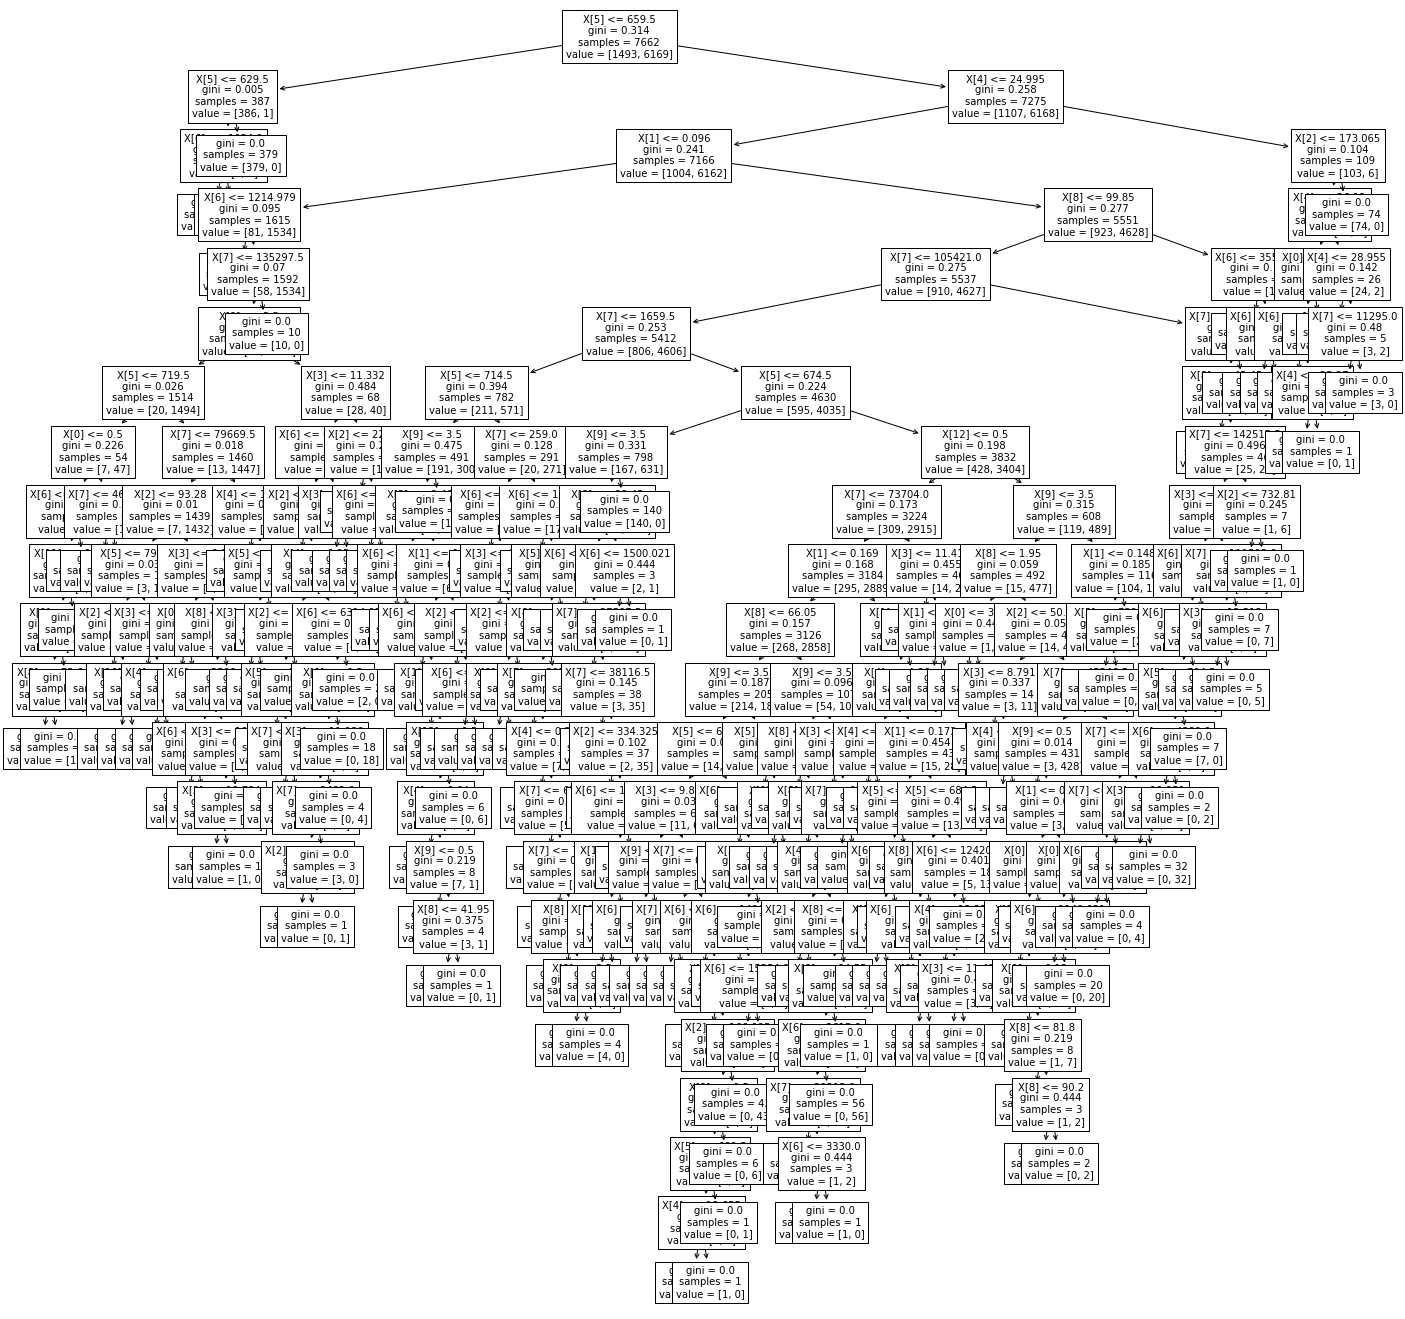

In [ ]:
plt.figure(figsize=(24,24))  # set plot size (denoted in inches)
sklearn.tree.plot_tree(classifiers[-1], fontsize=10)
plt.show()

Partially from there: https://habr.com/ru/company/otus/blog/523818/
And from there: https://www.soa.org/4a6af7/globalassets/assets/files/e-business/pd/events/2020/predictive-analytics-4-0/pd-2020-09-pas-session-014.pdf

### Questions
1. How did the DT compare to the RF in performance? Why?
    
Pretty same, almost no difference. I think because some features could affect a lot, and moreover since Single Tree guess good, Random Forest won't make it good enough, because choosing the best among the best with the minimum difference will be the same.

2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    
I could get +0.5% on Single Tree with maximum depth equal to 10. In fact, this is nonsense, it can be either an accident or a successful data comparison. Btw, max depth for single tree is possible to stay 10, whereas for random forest is random classifier is 21, so, that's interesting. It could be also because of bootstrapping, since it trains on different random number of data.

3. What is ensemble learning? What are its pros and cons?
    
Using Ensemble Learning, you can combine the predictions of two or more models to obtain a more reliable and productive model. With classification, models can be given the opportunity to choose labels. The label that was chosen most often is the one that will be chosen by the new model. Ensemble Learning can be used to improve the bias/variance balance in any cases, but when model errors are not positively correlated, the use of EL can lead to improved performance.

    1. Ensemble can create lower variance and lower bias. (+)
    2. Generally, ensembles have higher predictive accuracy. (+)
    3. Bagging, boosting, stacking could help us.(+)
    4. Ensembles can be more difficult to interpret. (-)
    5. Ensembles cost more to create, train, and deploy. (-)

4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    
Boosting is a procedure for sequentially constructing the composition of machine learning algorithms, when each subsequent algorithm seeks to compensate for the shortcomings of the composition of all previous algorithms.

In last step of bagging could be, e.g.:
1. Consensus: if all elementary classifiers have assigned the same label to an object, then we assign the object to the selected class.
2. Simple majority: consensus is very rarely achievable, so the simple majority method is most often used.

Random Forest is bagging approach.

Bagging meta estimator: the original data set is used to create some random subsets which is nothing but bagging or Bootstrapping. All features are included in the subsets of the data set. A suitable base estimator is fitted on each of the small sets. The final result will be a combination of predictions from each mode.

Random forest: some random subsets are generated from the original dataset. Only a random set of features are considered to decide the best split, at each node in the decision tree. Each subset is fitted on the decision tree model. The final prediction is nothing but the average of the predictions from all decision trees.

AdaBoost: It combines the group of weak learner base on weight age to create a strong learner. In the first iteration, it gives equal weight to each data set and the starts predicting that data set. If incorrect prediction occurs, it gives high weight to that observation. Adaptive Boosting repeat this procedure in the next iteration phase and continue until the accuracy has been achieved. Then combines this to create a strong prediction.

Gradient Boosting: It relies on the intuition that the best possible next model, when combined with previous models, minimizes the overall prediction error. The key idea is to set the target outcomes for this next model in order to minimize the error. The target outcome for each case in the data depends on how much changing that case's prediction impacts the overall prediction error. Each new model takes a step in the direction that minimizes prediction error, in the space of possible predictions for each training case.



# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [ ]:
# TODO: Implement task 4

### Questions
1. How did your model perform? Why is it better/worse?
    - *Answer*
2. What is domain gap in the context of ML?
    - *Answer*
3. Suggest two ways through which the problem of domain gap can be tackled.
    - *Answer*